# Facial Keypoints Detection

Importation des librairies:

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, AvgPool2D, BatchNormalization, Dropout, Activation, MaxPooling2D
from keras.optimizers import Adam
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

Using TensorFlow backend.


Importation des donnees:

In [3]:
train = pd.read_csv('C:/Users/elbar/OneDrive/Desktop/training.csv')  
test = pd.read_csv('C:/Users/elbar/OneDrive/Desktop/test.csv')
IdLookupTable = pd.read_csv('C:/Users/elbar/OneDrive/Desktop/IdLookupTable.csv')
SampleSubmission = pd.read_csv('C:/Users/elbar/OneDrive/Desktop/SampleSubmission.csv')

In [43]:
train.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,"[[238, 236, 237, 238, 240, 240, 239, 241, 241,..."
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,"[[219, 215, 204, 196, 204, 211, 212, 200, 180,..."
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,"[[144, 142, 159, 180, 188, 188, 184, 180, 167,..."
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,"[[193, 192, 193, 194, 194, 194, 193, 192, 168,..."
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,"[[147, 148, 160, 196, 215, 214, 216, 217, 219,..."


In [44]:
train.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

Donnees manquantes:

In [4]:
train.isnull().any().value_counts()

True     28
False     3
dtype: int64

Remplissage des valeurs manquantes avec la valeur precedante de chaque enregistrement:

In [5]:
train.fillna(method = 'ffill',inplace = True)

Verification du remplissage:

In [6]:
train.isnull().any().value_counts()

False    31
dtype: int64

Remodeler la colonne 'Image' en une image de 96*96 pixels:

In [7]:
train['Image'] = train['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((96,96)))
test['Image'] = test['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((96,96)))

Creation d'une fonction qui affiche les images avec les markers representant les keypoints:

In [8]:
def affichage(data, index):
    image = plt.imshow(data['Image'][index],cmap='gray')
    l = []
    for i in range(1,31,2):
        l.append(plt.plot(data.loc[index][i-1], data.loc[index][i], 'ro',markersize=2))
        
    return image, l

Affichage de 16 images depuis la base de donnees de training:

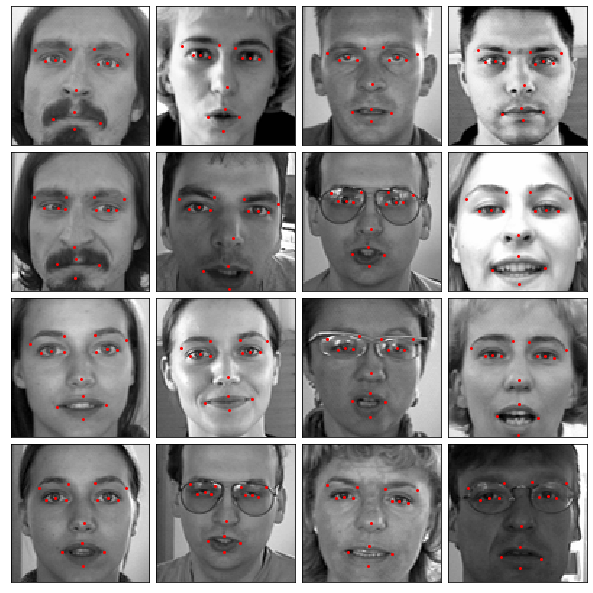

In [9]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    affichage(train, i)

plt.show()

X contient la colonnes des images de la base de donnees de training, et y la dataframe training sans colonne des images:

In [10]:
X = np.asarray([train['Image']], dtype=np.uint8).reshape(train.shape[0],96,96,1)
y = train.drop(['Image'], axis=1)

In [11]:
X.shape

(7049, 96, 96, 1)

In [12]:
y.shape

(7049, 30)

In [13]:
y2 = y.to_numpy()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.3, random_state=42)

# Fully Connected NN

In [30]:
fcn = Sequential()
fcn.add(Flatten())
fcn.add(Dense(512,input_shape=(96, 96,1)))
fcn.add(Activation('relu'))
fcn.add(Dropout(0.5))
fcn.add(Dense(450))
fcn.add(Dense(400))
fcn.add(Dense(350))
fcn.add(Dense(300))
fcn.add(Dense(250))
fcn.add(Dense(200))
fcn.add(Dense(150))
fcn.add(Dense(100))
fcn.add(Dense(30))

In [31]:
fcn.compile(optimizer='Adam', 
              loss='mse',
              metrics=['mae'])

In [37]:
fcn.fit(X_train, y_train, epochs=50)

Epoch 1/50
4934/4934 [==============================] - 34s 7ms/step - loss: 635.2608 - mean_absolute_error: 19.5916
Epoch 2/50
4934/4934 [==============================] - 31s 6ms/step - loss: 610.4752 - mean_absolute_error: 19.1336
Epoch 3/50
4934/4934 [==============================] - 32s 7ms/step - loss: 620.6720 - mean_absolute_error: 19.3659
Epoch 4/50
4934/4934 [==============================] - 35s 7ms/step - loss: 610.9858 - mean_absolute_error: 19.1820
Epoch 5/50
4934/4934 [==============================] - 32s 6ms/step - loss: 569.9823 - mean_absolute_error: 18.4977
Epoch 6/50
4934/4934 [==============================] - 32s 6ms/step - loss: 560.3098 - mean_absolute_error: 18.3776
Epoch 7/50
4934/4934 [==============================] - 32s 7ms/step - loss: 555.8141 - mean_absolute_error: 18.2881
Epoch 8/50
4934/4934 [==============================] - 31s 6ms/step - loss: 550.0561 - mean_absolute_error: 18.1983
Epoch 9/50
4934/4934 [==============================] - 32s 7ms/

In [38]:
sc = fcn.evaluate(X_test, y_test, verbose=0)
print('Test loss:', sc[0])
print('Test accuracy:', sc[1])

Test loss: 8.38015122424908
Test accuracy: 1.7446598814452512


In [39]:
test_res1=fcn.predict(X_test)

In [40]:
from math import sqrt
from sklearn.metrics import mean_squared_error
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = test_res1))
print(RMSE)

2.894848993736212


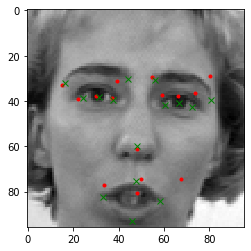

In [47]:
predicts = fcn.predict(X_train)
n = 22

xv = X_train[n].reshape((96,96))
plt.imshow(xv,cmap='gray')

for i in range(1,31,2):
    plt.plot(predicts[n][i-1], predicts[n][i], 'ro',markersize=3)
    plt.plot(y_train[n][i-1], y_train[n][i], 'x', color='green')

plt.show()

# CNN

Definition du model:

In [15]:
model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 96, 32)        128       
_______________

Pour 'the loss function' on utlise 'mean squared error', et on evalue le resultat avec 'mean absolute error'

In [17]:
import tensorflow as tf
model.compile(optimizer='Adam', 
              loss='mse',
              metrics=['mae'])

Entrainement du model:

In [19]:
history = model.fit(X_train, y_train, epochs=50)

Epoch 1/50
4934/4934 [==============================] - 350s 71ms/step - loss: 28.8987 - mean_absolute_error: 4.0873
Epoch 2/50
4934/4934 [==============================] - 360s 73ms/step - loss: 17.5237 - mean_absolute_error: 3.1742
Epoch 3/50
4934/4934 [==============================] - 363s 74ms/step - loss: 14.5696 - mean_absolute_error: 2.8775
Epoch 4/50
4934/4934 [==============================] - 373s 76ms/step - loss: 12.7445 - mean_absolute_error: 2.6722
Epoch 5/50
4934/4934 [==============================] - 349s 71ms/step - loss: 11.3109 - mean_absolute_error: 2.5013
Epoch 6/50
4934/4934 [==============================] - 315s 64ms/step - loss: 10.1899 - mean_absolute_error: 2.3641
Epoch 7/50
4934/4934 [==============================] - 314s 64ms/step - loss: 10.0589 - mean_absolute_error: 2.3482
Epoch 8/50
4934/4934 [==============================] - 314s 64ms/step - loss: 10.5785 - mean_absolute_error: 2.4124
Epoch 9/50
4934/4934 [==============================] - 318s 65m

In [45]:
model.save('cnn50.h5')

Evauation du model:

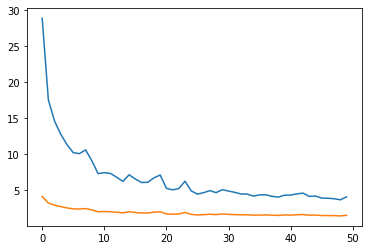

In [21]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['mean_absolute_error'])
pyplot.show()

In [22]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.830479946429566
Test accuracy: 1.1525420372085933


Prediction des keypoints pour la colonne Image de test:

In [23]:
test_X = np.asarray([test['Image']], dtype=np.uint8).reshape(test.shape[0],96,96,1)
test_res = model.predict(test_X)

In [24]:
test_res2=model.predict(X_test)

In [25]:
y_test.shape

(2115, 30)

In [26]:
test_X.shape

(1783, 96, 96, 1)

In [27]:
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = test_res2))
print(RMSE)

1.957161133331921


Comparaison entre le resultat de la prediction du train dataset avec les keypoints reeles:

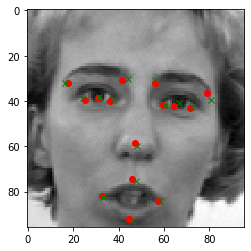

In [28]:
train_predicts = model.predict(X_train)
n = 22

xv = X_train[n].reshape((96,96))
plt.imshow(xv,cmap='gray')

for i in range(1,31,2):
    plt.plot(train_predicts[n][i-1], train_predicts[n][i], 'ro')
    plt.plot(y_train[n][i-1], y_train[n][i], 'x', color='green')

plt.show()

Enregistrement des reultats dans un fichier csv:

In [29]:
header = list(y.columns)
test_predicts = pd.DataFrame(test_res, columns = header)
for i in range(IdLookupTable.shape[0]):
    IdLookupTable.Location[i] = test_predicts.loc[IdLookupTable.ImageId[i]-1][IdLookupTable.FeatureName[i]]
SampleSubmission.Location = IdLookupTable.Location
my_submission = SampleSubmission
my_submission.to_csv('sub5.csv', index=False)
my_submission

C:\Users\ayman\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,RowId,Location
0,1,65.493965
1,2,39.225254
2,3,29.656908
3,4,37.254635
4,5,60.431892
...,...,...
27119,27120,39.710720
27120,27121,45.527462
27121,27122,61.999035
27122,27123,45.746319
